**Predicción de precio de coches de segunda mano** 
El objetivo de este proyecto es crear un predictor de precios de coches de segunda mano lo más fiable posible, así si queremos vender nuestro viejo coche o comprar  podemos predecir su precio ideal.
**¿Cómo lo he creado?**
Mediante un data set de muestra en el que tenemos la venta de coches de segunda mano, clasificado por precios, kilómetros, color, tipo de combustible, fecha de venta, etc.
Además de eso creo que un punto muy importante hoy en día es el precio de los combustibles, no se venden igual los vehículos de Diesel antes que en estos momentos. Por eso he decidido añadir el precio de los combustibles por meses.



In [1]:
#Básicos

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


#Visualización
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt


#Modelos
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost

In [2]:
coches_usados= pd.read_csv("coches_segunda_mano.csv")

In [3]:
#Elimino las columnas que son interesantes para el análisis.
coches_usados.drop(['url','company','price_financed','photos',
                    'dealer','country','shift','insert_date','version'],axis=1,inplace=True)
                    #Cambio el nombre a las columnas para hacerlo más entendible.
coches_usados.set_axis(['Marca', 'Modelo','precio','Combustible',
                        'Año_del_vehiculo','kilometros','Caballos','puertas','color_coche',
                        'profesional','Comunidad_autonoma','Año_de_venta'], axis=1,inplace=True)

In [4]:
#bucle para cambiar el nombre de las provincias a sus respectivas comunidades autonomas
for i in coches_usados['Comunidad_autonoma']:
    if i == 'Almería'or i == 'Granada'or i =='Córdoba' or i== 'Jaén' or i =='Sevilla' or i== 'Málaga' or i =='Cádiz' or i== 'Huelva':
        coches_usados['Comunidad_autonoma'].replace(i,'Andalucía',inplace=True)
    elif i== 'Huesca' or i =='Zaragoza' or i=='Teruel':
        coches_usados['Comunidad_autonoma'].replace(i,'Aragón',inplace=True)
    elif i=='Toledo' or i =='Guadalajara' or i=='Albacete' or i == 'Cuenca' or i =='Ciudad Real':
        coches_usados['Comunidad_autonoma'].replace(i,'Castilla la Mancha',inplace=True)
    elif i=='León' or i =='Palencia' or i=='Salamanca' or i == 'Burgos' or i == 'Zamora' or i =='Valladolid' or i =='Soria' or i =='Segovia' or i == 'Ávila':
        coches_usados['Comunidad_autonoma'].replace(i,'Castilla y León',inplace=True)
    elif i=='Barcelona' or i == 'Tarragona' or i =='Lérida' or i=='Gerona' or i=='Lleida' or i=='Girona':
        coches_usados['Comunidad_autonoma'].replace(i,'Cataluña',inplace=True)
    elif i =='Caceres' or i =='Badajoz' or i =='Cáceres':
        coches_usados['Comunidad_autonoma'].replace(i,'Extremadura',inplace=True)
    elif i== 'Álava' or i =='Guipúzcoa' or i =='Vizcaya':
        coches_usados['Comunidad_autonoma'].replace(i,'País Vasco',inplace=True)
    elif i=='Castellón' or i =='Valencia' or i =='Alicante':
        coches_usados['Comunidad_autonoma'].replace(i,'Comunidad Valenciana',inplace=True)
    elif i =='La coruña' or i== 'Lugo' or i=='Ourense' or i=='Pontevedra'or i == 'A Coruña' or i=='Orense':
        coches_usados['Comunidad_autonoma'].replace(i,'Galicia',inplace=True)
    elif i == 'Tenerife' or i == 'Las Palmas':
        coches_usados['Comunidad_autonoma'].replace(i,'Islas Canarias',inplace=True)
    elif i == 'Baleares':
        coches_usados['Comunidad_autonoma'].replace(i,'Islas_Baleares',inplace=True)
    elif i == 'Madrid':
        coches_usados['Comunidad_autonoma'].replace(i,'Madrid',inplace=True)
    elif i == 'Madrid':
        coches_usados['Comunidad_autonoma'].replace(i,'Navarra',inplace=True)
    elif i == 'Madrid':
        coches_usados['Comunidad_autonoma'].replace(i,'Asturias',inplace=True)
    elif i == 'La Rioja':
        coches_usados['Comunidad_autonoma'].replace(i,'La rioja',inplace=True)                                              
    elif i == 'Murcia':
        coches_usados['Comunidad_autonoma'].replace(i,'Murcia',inplace=True) 
    elif i == 'Cantabria':
        coches_usados['Comunidad_autonoma'].replace(i,'Cantabria',inplace=True) 

In [5]:
'''
elimino las filas con valores que son Ceuta y Melilla ya que no estoy
analizando esas ciudades por falta de muestras.
'''


for index,row in coches_usados.iterrows():
    if row['Comunidad_autonoma'] == 'Ceuta' or row['Comunidad_autonoma'] =='Melilla' :
        coches_usados=coches_usados.drop(index)



In [6]:

#eliminino todos los coches profesionales.
filtro_profesional = coches_usados['profesional'] == False
coches_usados=coches_usados[filtro_profesional]
# y la columna de si es profesional
coches_usados.drop(['profesional'],axis=1,inplace=True)



In [7]:
#Modifico el campo de fecha, quiero el año y mes de venta en columnas separadas
coches_usados[['Año_Venta', 'Mes_Venta','dia']] = coches_usados['Año_de_venta'].str.split('-',3,expand=True)
#borro la columna que no nos vale
coches_usados.drop(['Año_de_venta','dia'],axis=1,inplace=True)

In [8]:
#como es una muestra grande elimino los null menos predecibles
coches_usados = coches_usados[coches_usados['Modelo'].notna()]
coches_usados = coches_usados[coches_usados['Comunidad_autonoma'].notna()]
coches_usados = coches_usados[coches_usados['Caballos'].notna()]

coches_usados = coches_usados[coches_usados['Marca'].notna()]



In [9]:
coches_usados

,Marca,Modelo,precio,Combustible,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta
7,HONDA,Civic,8200,Diésel,2012.0,203000,150.0,5,Blanco,Cataluña,2020,12
8,CITROEN,Berlingo,12100,Gasolina,2018.0,45000,110.0,5,Azul,Comunidad Valenciana,2020,11
9,NISSAN,NOTE,6300,Gasolina,2016.0,77000,80.0,5,Blanco,Cataluña,2020,12
12,VOLKSWAGEN,Polo,1300,Gasolina,2001.0,217000,75.0,3,Azul,Cataluña,2020,11
20,FIAT,Doblò,8000,Diésel,2010.0,135000,120.0,5,Granate,Navarra,2020,11
...,...,...,...,...,...,...,...,...,...,...,...,...
49952,MERCEDES-BENZ,Clase E,5400,Diésel,2003.0,326000,204.0,4,Azul,País Vasco,2020,12
49966,KIA,Sportage,11000,Diésel,2012.0,195000,136.0,5,Marrón,Islas Canarias,2020,12
49977,OPEL,Corsa,1190,Gasolina,2001.0,89814,90.0,3,Rojo,Andalucía,2020,10
49978,VOLKSWAGEN,Passat,5500,Diésel,2009.0,180000,110.0,5,Gris / Plata,Andalucía,2020,12


In [10]:
coches_usados=coches_usados.groupby(['Modelo'], group_keys = False).apply(lambda x: x.fillna(x.mode().iloc[0]))
coches_usados=coches_usados.groupby(['color_coche'], group_keys = False).apply(lambda x: x.fillna(x.mode().iloc[0]))

In [11]:
print (coches_usados['Marca']. unique ())
#vemos que aun quedan marcas de coches indrustriales como UMM o IVECO, los elimino, DS no es una marca
valores=['IVECO-PEGASO','UMM','IVECO']
coches_usados = coches_usados[~coches_usados.isin(valores)]



['PEUGEOT' 'NISSAN' 'FIAT' 'AUDI' 'OPEL' 'HYUNDAI' 'CITROEN' 'VOLKSWAGEN'
 'CHEVROLET' 'MERCEDES-BENZ' 'RENAULT' 'SEAT' 'IVECO' 'MINI' 'KIA' 'VOLVO'
 'BMW' 'FORD' 'ALFA ROMEO' 'CHRYSLER' 'MAZDA' 'ABARTH' 'PORSCHE' 'SAAB'
 'HONDA' 'TOYOTA' 'CADILLAC' 'SUBARU' 'JEEP' 'BENTLEY' 'DS' 'LAND-ROVER'
 'DACIA' 'GALLOPER' 'JAGUAR' 'SKODA' 'LEXUS' 'SUZUKI' 'MITSUBISHI'
 'DAEWOO' 'MASERATI' 'ROVER' 'MORGAN' 'INFINITI' 'SSANGYONG' 'LANCIA'
 'SMART' 'SANTANA' 'DODGE' 'ISUZU' 'IVECO-PEGASO' 'LOTUS' 'LAMBORGHINI'
 'TATA' 'TESLA' 'ASTON MARTIN' 'MAHINDRA' 'MG' 'PONTIAC' 'AUSTIN' 'UMM'
 'FERRARI']


In [12]:
#creo una nueva columna que se llame unidades para poder sumar los vechilos
coches_usados.insert(0, 'Unidad', 1)

In [13]:
print (coches_usados['color_coche']. unique ())

#nos vamos a quedar solo con el primer color

def primera_palabra(palabra):
    return palabra.split(' ')[0]

coches_usados['color_coche']=coches_usados['color_coche'].apply(primera_palabra)

['Amarillo' 'Azul' 'Azul (2)' 'Azul (???)' 'Azul (Negro)' 'Azul (Verde)'
 'Azul (blue)' 'Beige' 'Blanco' 'Blanco (4)' 'Blanco (Blanc)'
 'Blanco (Weiß)' 'Blanco (White)' 'Granate' 'Gris / Plata'
 'Gris / Plata (6)' 'Gris / Plata (????? ???????????)' 'Marrón'
 'Marrón (6)' 'Marrón (7)' 'Marrón (Granate)' 'Marrón (Gris / Plata)'
 'Naranja' 'Negro' 'Negro (9)' 'Negro (??????)' 'Negro (Blanco)'
 'Negro (Noir)' 'Negro (Preto)' 'Negro (Svart)' 'Rojo' 'Rojo (Rosa)'
 'Rojo (vermell)' 'Rosa' 'Verde' 'Verde (Gris / Plata)' 'Violeta / Lila']


In [38]:
coches_usados['Mes_Venta'].unique()

array(['11', '10', '01', '12', '09', '03', '08', '02', '07', '05'],
      dtype=object)

In [39]:
coches_usados

,Unidad,Marca,Modelo,precio,Combustible,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta
33232,1,PEUGEOT,107,3990,Diésel,2006.0,155000,54.0,5,Amarillo,Galicia,2020,11
25571,1,PEUGEOT,206,2000,Gasolina,2004.0,188000,90.0,5,Amarillo,Andalucía,2020,10
17564,1,NISSAN,350Z,27499,Gasolina,2005.0,15000,300.0,3,Amarillo,Galicia,2021,01
46930,1,FIAT,500,6300,Gasolina,2015.0,130000,69.0,3,Amarillo,Islas Canarias,2021,01
17060,1,AUDI,A3,14500,Diésel,2014.0,110000,150.0,5,Amarillo,Cataluña,2020,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8599,1,SSANGYONG,Rexton,6900,Diésel,2006.0,115000,165.0,5,Violeta,Cataluña,2020,11
26885,1,SUZUKI,SX4 S-Cross,8999,Diésel,2014.0,52000,120.0,5,Violeta,Comunidad Valenciana,2021,01
30751,1,CHRYSLER,Stratus,900,Gasolina,1997.0,127000,131.0,4,Violeta,Madrid,2020,12
43033,1,VOLKSWAGEN,Touran,5800,Diésel,2007.0,188258,140.0,5,Violeta,Murcia,2020,12


In [14]:

url="https://datosmacro.expansion.com/energia/precios-gasolina-diesel-calefaccion/espana?anio=2021"
tablas=pd.read_html(url)
tabla2021=tablas[0]
tabla2021.drop([49],axis=0,inplace=True)

url="https://datosmacro.expansion.com/energia/precios-gasolina-diesel-calefaccion/espana?anio=2020"
tablas=pd.read_html(url)
tabla2020=tablas[0]
tabla2020.drop([39],axis=0,inplace=True)


url="https://datosmacro.expansion.com/energia/precios-gasolina-diesel-calefaccion/espana?anio=2019"
tablas=pd.read_html(url)
tabla2019=tablas[0]
tabla2019.drop([49],axis=0,inplace=True)


url="https://datosmacro.expansion.com/energia/precios-gasolina-diesel-calefaccion/espana?anio=2018"
tablas=pd.read_html(url)
tabla2018=tablas[0]
tabla2018.drop([50],axis=0,inplace=True)


url="https://datosmacro.expansion.com/energia/precios-gasolina-diesel-calefaccion/espana?anio=2017"
tablas=pd.read_html(url)
tabla2017=tablas[0]
tabla2017.drop([50],axis=0,inplace=True)


In [15]:
tablas=[tabla2021,tabla2020,tabla2019,tabla2018,tabla2017]
tablagasolina=pd.concat(tablas)

In [45]:
tablagasolina

,Año,Mes,Super_95,Diesel
0,2017,01,1.242000,1.128000
1,2017,02,1.250000,1.127500
2,2017,03,1.230000,1.115000
3,2017,04,1.240000,1.110000
4,2017,05,1.220000,1.090000
5,2017,06,1.187500,1.057500
6,2017,07,1.176000,1.050000
7,2017,08,1.190000,1.070000
8,2017,09,1.210000,1.085000
9,2017,10,1.206000,1.108000


In [16]:

#cambiamos de nombre las columnas para evitar posibles problemas
tablagasolina.set_axis(['Fecha', 'Super_95', 'Super95_Sinimp',
                                  'Diesel', 'Diesel_Sin_imp','Diesel_Cal',
                                  'Diesel_Cal_sin'], axis=1,inplace=True) 

#eliminamos las columas que no vamos a usar, solo necesitamos super_95 y Diesel, no vamos a usar sin impuestos
tablagasolina.drop(['Super95_Sinimp','Diesel_Sin_imp',
                                'Diesel_Cal','Diesel_Cal_sin'],axis=1,inplace=True)


In [17]:
tablagasolina[['borrar','Mes', 'Año']] = tablagasolina['Fecha'].str.split('/',2,expand=True)

In [47]:
tablagasolina

tablagasolina.to_csv('tabla_gasolina.csv', index=False)

In [18]:
#cambiamos , por . 
tablagasolina['Diesel'] = tablagasolina['Diesel'].replace({'€':''}, regex = True).replace({',':'.'}, regex = True).replace({' ':''}, regex = True).astype('float').round(2)
tablagasolina['Super_95'] = tablagasolina['Super_95'].replace({'€':''}, regex = True).replace({',':'.'}, regex = True).replace({' ':''}, regex = True).astype('float').round(2)

In [19]:
#hay que transformar la columna de Diesel y gasolina en float, pero hay que quitar el euro primero
tablagasolina.Diesel = tablagasolina.Diesel.astype('str')
tablagasolina.Super_95 = tablagasolina.Super_95.astype('str')

In [20]:


#pasamos las filas de combustible a float para despues hacer la media
tablagasolina.Diesel = tablagasolina.Diesel.astype('float')
tablagasolina.Super_95 = tablagasolina.Super_95.astype('float')

In [21]:
#hacemos la media por meses
tablagasolina=tablagasolina.groupby(['Año', 'Mes']).mean().reset_index()

In [22]:
#hacemos la media por meses
tablagasolina=tablagasolina.groupby(['Año', 'Mes']).mean().reset_index()

In [42]:
tablagasolina

,Año,Mes,Super_95,Diesel
0,2017,01,1.242000,1.128000
1,2017,02,1.250000,1.127500
2,2017,03,1.230000,1.115000
3,2017,04,1.240000,1.110000
4,2017,05,1.220000,1.090000
5,2017,06,1.187500,1.057500
6,2017,07,1.176000,1.050000
7,2017,08,1.190000,1.070000
8,2017,09,1.210000,1.085000
9,2017,10,1.206000,1.108000


In [41]:
coches_usados

,Unidad,Marca,Modelo,precio,Combustible,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta
33232,1,PEUGEOT,107,3990,Diésel,2006.0,155000,54.0,5,Amarillo,Galicia,2020,11
25571,1,PEUGEOT,206,2000,Gasolina,2004.0,188000,90.0,5,Amarillo,Andalucía,2020,10
17564,1,NISSAN,350Z,27499,Gasolina,2005.0,15000,300.0,3,Amarillo,Galicia,2021,01
46930,1,FIAT,500,6300,Gasolina,2015.0,130000,69.0,3,Amarillo,Islas Canarias,2021,01
17060,1,AUDI,A3,14500,Diésel,2014.0,110000,150.0,5,Amarillo,Cataluña,2020,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8599,1,SSANGYONG,Rexton,6900,Diésel,2006.0,115000,165.0,5,Violeta,Cataluña,2020,11
26885,1,SUZUKI,SX4 S-Cross,8999,Diésel,2014.0,52000,120.0,5,Violeta,Comunidad Valenciana,2021,01
30751,1,CHRYSLER,Stratus,900,Gasolina,1997.0,127000,131.0,4,Violeta,Madrid,2020,12
43033,1,VOLKSWAGEN,Touran,5800,Diésel,2007.0,188258,140.0,5,Violeta,Murcia,2020,12


In [23]:
#analisis= pd.merge(coches_usados,tablagasolina,  how='left',
                     #left_on=['Año_Venta','Mes_Venta'], right_on = ['Año','Mes'])

In [43]:
def unir_dataframes(df1, df2, how,left_on, right_on):
    '''funcion que hace un marge con 2 columnas
    pudiendo elegir las columnas de union
    y el como'''
    analisis = pd.merge(df1, df2, how=how,left_on=left_on, right_on=right_on)
    return analisis


analisis = unir_dataframes(coches_usados, tablagasolina,'inner',['año_Venta','Mes_Venta'],['Año','Mes'])

KeyError: 'año_Venta'

In [35]:
analisis

,Unidad,Marca,Modelo,precio,Combustible,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta,Año,Mes,Super_95,Diesel,marca_modelo,fecha
0,1,PEUGEOT,107,3990,Diésel,2006.0,155000,54.0,5,Amarillo,Galicia,2020,11,2020,11,1.154000,1.024000,PEUGEOT 107,2020-11-01
1,1,PEUGEOT,206,2000,Gasolina,2004.0,188000,90.0,5,Amarillo,Andalucía,2020,10,2020,10,1.160000,1.030000,PEUGEOT 206,2020-10-01
2,1,NISSAN,350Z,27499,Gasolina,2005.0,15000,300.0,3,Amarillo,Galicia,2021,01,2021,01,1.216667,1.096667,NISSAN 350Z,2021-01-01
3,1,FIAT,500,6300,Gasolina,2015.0,130000,69.0,3,Amarillo,Islas Canarias,2021,01,2021,01,1.216667,1.096667,FIAT 500,2021-01-01
4,1,AUDI,A3,14500,Diésel,2014.0,110000,150.0,5,Amarillo,Cataluña,2020,12,2020,12,1.176667,1.060000,AUDI A3,2020-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,1,SSANGYONG,Rexton,6900,Diésel,2006.0,115000,165.0,5,Violeta,Cataluña,2020,11,2020,11,1.154000,1.024000,SSANGYONG Rexton,2020-11-01
9059,1,SUZUKI,SX4 S-Cross,8999,Diésel,2014.0,52000,120.0,5,Violeta,Comunidad Valenciana,2021,01,2021,01,1.216667,1.096667,SUZUKI SX4 S-Cross,2021-01-01
9060,1,CHRYSLER,Stratus,900,Gasolina,1997.0,127000,131.0,4,Violeta,Madrid,2020,12,2020,12,1.176667,1.060000,CHRYSLER Stratus,2020-12-01
9061,1,VOLKSWAGEN,Touran,5800,Diésel,2007.0,188258,140.0,5,Violeta,Murcia,2020,12,2020,12,1.176667,1.060000,VOLKSWAGEN Touran,2020-12-01


In [24]:


111analisis['marca_modelo'] = analisis.Marca.str.cat(analisis.Modelo, sep=' ')

In [25]:
#uno mes y año
analisis['fecha'] = analisis.Mes.str.cat(analisis.Año, sep='/')
#paso a datetime
analisis['fecha'] = pd.to_datetime(analisis['fecha'])

**Ahora voy a analizar el mercado del turismo de segunda mano con graficas**

In [26]:
#¿Cuál es el top 5 de las marcas de coches más vendidas?

n = 5
top5=analisis['Marca'].value_counts()[:n].index.tolist()

top5dt=analisis[analisis['Marca'].isin(top5)].groupby(['Marca'])['Unidad'].sum().reset_index()
top5dt.sort_values(by=['Unidad'], inplace=True, ascending=False)


fig = px.bar(top5dt, x='Marca', y='Unidad')
fig.show()

In [27]:
#¿Cuál es el combustible mas vendido por comunidades?


fig2 = px.histogram(analisis, x='Comunidad_autonoma', y='Unidad', color='Combustible',
                    barmode='group')
fig2.show()



In [28]:
#Tras ver los resultados, me he preguntado¿Los coches Diesel son más baratos?

dfdisel=analisis.groupby('Combustible')['precio'].median().reset_index().sort_values('precio',ascending=False)

fig9 = px.bar(dfdisel,x='Combustible',
            y='precio',
            color='Combustible',
            title='Precio medio por Combustible de coches',text_auto='.2s')

fig9.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig9.show()

In [29]:
#¿Está el precio relacionado con los kilometros recorridos?Para comprobarlo usaremos el modelo más usado.


marca_pais=analisis.groupby(['marca_modelo'])['Unidad'].sum().reset_index().sort_values('Unidad',ascending=False).head(10)

fig = px.pie(marca_pais, values='Unidad', names='marca_modelo', title='Coches más vendidos')
fig.show()

#vemos que es el bmv serie 3. Ahora vamos a ver su precio en función de los kilometros recorreidos


filtro_bmv = analisis['marca_modelo'] == 'BMW Serie 3'

bmw=analisis[filtro_bmv]





fig = px.scatter(bmw, x="kilometros", y="precio")
fig.show()

#vemos que la tendendecia es cuantos más kilometros, más barato es el coche.


In [30]:
#¿Cómo es la venta por colores?

colores=analisis.groupby(['color_coche'])['Unidad'].sum().reset_index().sort_values('Unidad',ascending=False)

fig = px.bar(colores, x='color_coche', y='Unidad',color='color_coche',color_discrete_map={'Gris':'grey',
                                 'Negro':'black',
                                 'Blanco':'floralwhite','Azul':'deepskyblue',
                                 'Rojo':'red',
                                 'Verde':'green',
                                 'Beige':'beige','Marrón':'saddlebrown',
                                 
                                 'Granate':'magenta',
                                 'Amarillo':'yellow',
                                 'Naranja':'orange',
                                 'Violeta':'darkviolet',
                                 'Rosa':'deeppink',
                                 })
fig.show()

In [31]:
#¿Los coches de 2 puertas tienen más caballos?, ¿hay correlación?


caballos=analisis.groupby(['Caballos','puertas'])['Unidad'].sum().reset_index().sort_values('Unidad',ascending=False)

fig = px.scatter(caballos, x="Caballos", y="Unidad", color='puertas')
fig.show()

#aparentemente no

In [32]:

analisis.to_excel('datos.xlsx', index=False)

In [33]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
#borro columnas que no necesito para los siguientes analisis


analisis.drop(['Unidad','Modelo',
                                'fecha','marca_modelo','Mes','Año'],axis=1,inplace=True)

In [50]:
analisis

,Marca,precio,Combustible,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta,Super_95,Diesel
0,PEUGEOT,3990,Diésel,2006.0,155000,54.0,5,Amarillo,Galicia,2020,11,1.154000,1.024000
1,PEUGEOT,2000,Gasolina,2004.0,188000,90.0,5,Amarillo,Andalucía,2020,10,1.160000,1.030000
2,NISSAN,27499,Gasolina,2005.0,15000,300.0,3,Amarillo,Galicia,2021,01,1.216667,1.096667
3,FIAT,6300,Gasolina,2015.0,130000,69.0,3,Amarillo,Islas Canarias,2021,01,1.216667,1.096667
4,AUDI,14500,Diésel,2014.0,110000,150.0,5,Amarillo,Cataluña,2020,12,1.176667,1.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9058,SSANGYONG,6900,Diésel,2006.0,115000,165.0,5,Violeta,Cataluña,2020,11,1.154000,1.024000
9059,SUZUKI,8999,Diésel,2014.0,52000,120.0,5,Violeta,Comunidad Valenciana,2021,01,1.216667,1.096667
9060,CHRYSLER,900,Gasolina,1997.0,127000,131.0,4,Violeta,Madrid,2020,12,1.176667,1.060000
9061,VOLKSWAGEN,5800,Diésel,2007.0,188258,140.0,5,Violeta,Murcia,2020,12,1.176667,1.060000


In [ ]:
#como hay muchisimas marcas de coches diferentes, voy a intentar relacionarlas para simplificar la variable

analisis['Marca'].unique()

array(['PEUGEOT', 'NISSAN', 'FIAT', 'AUDI', 'OPEL', 'HYUNDAI', 'CITROEN',
       'VOLKSWAGEN', 'CHEVROLET', 'MERCEDES-BENZ', 'RENAULT', 'SEAT', nan,
       'MINI', 'KIA', 'VOLVO', 'BMW', 'FORD', 'ALFA ROMEO', 'CHRYSLER',
       'MAZDA', 'ABARTH', 'PORSCHE', 'SAAB', 'HONDA', 'TOYOTA',
       'CADILLAC', 'SUBARU', 'JEEP', 'BENTLEY', 'DS', 'LAND-ROVER',
       'DACIA', 'GALLOPER', 'JAGUAR', 'SKODA', 'LEXUS', 'SUZUKI',
       'MITSUBISHI', 'DAEWOO', 'MASERATI', 'ROVER', 'MORGAN', 'INFINITI',
       'SSANGYONG', 'LANCIA', 'SMART', 'SANTANA', 'DODGE', 'ISUZU',
       'LOTUS', 'LAMBORGHINI', 'TATA', 'TESLA', 'ASTON MARTIN',
       'MAHINDRA', 'MG', 'PONTIAC', 'AUSTIN', 'FERRARI'], dtype=object)

In [ ]:
df = px.data.tips()
fig = px.box(analisis, x="Marca", y="precio")
fig.show()

'''en el grafico se puede apreciar  que se pueden divir en 3 o en 4 grupos por tipo de precio'''

'en el grafico se puede apreciar  que se pueden divir en 3 o en 4 grupos por tipo de precio'

In [ ]:
grupos=analisis.groupby(['Marca'])['precio'].median().reset_index().round(2).sort_values('precio')


fig = px.bar(grupos, x='Marca', y='precio')
fig.show()

#esta es el relación entre marcas y precio, ahora si lo podemos divir en 3 gamas
#gama alta, media y baja

In [51]:
analisis['Marca']=pd.factorize(analisis.Marca)[0]
#voy a hacer un cluster para agrupar por precios
from sklearn.cluster import KMeans

precios=analisis[['precio','Caballos','Marca']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(precios)

analisis['cluster'] = kmeans.labels_

In [ ]:
analisis.drop(['Marca'], axis=1,inplace=True)

In [ ]:
cols = ['precio','Combustible', 'Año_del_vehiculo', 'kilometros','Caballos', 'puertas','Año_Venta',

'Mes_Venta','cluster'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = analisis[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = analisis[cols].quantile(0.75)
IQR = Q3 - Q1

# Return a boolean array of the rows with (any) non-outlier column values
condition = ~((analisis[cols] < (Q1 - 1.5 * IQR)) | (analisis[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter our dataframe based on condition
analisis = analisis[condition]

In [ ]:
analisis=pd.get_dummies(analisis,columns=['Combustible'],prefix=['combus'])

analisis['Comunidad_autonoma']=pd.factorize(analisis.Comunidad_autonoma)[0]


analisis['color_coche']=pd.factorize(analisis.color_coche)[0]

In [ ]:
#borro una columna de cada getdumie

analisis.drop(['combus_Híbrido enchufable'], axis=1,inplace=True)

In [ ]:
analisis.dtypes
analisis['Año_Venta'] = analisis['Año_Venta'].astype('float64')
analisis['Mes_Venta'] = analisis['Mes_Venta'].astype('float64')

In [ ]:
pip install numpy --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:

corr_df = analisis.corr(method='pearson')


corr_df.style.background_gradient(cmap='coolwarm')


,precio,Año_del_vehiculo,kilometros,Caballos,puertas,color_coche,Comunidad_autonoma,Año_Venta,Mes_Venta,Super_95,Diesel,cluster,combus_Diésel,combus_Eléctrico,combus_Gas licuado (GLP),combus_Gas natural (CNG),combus_Gasolina,combus_Híbrido
precio,1.000000,0.719808,-0.513426,0.482240,0.169186,-0.018781,-0.007227,0.032440,-0.033575,0.019484,0.013166,0.787700,0.085384,0.034938,-0.002411,0.000151,-0.128664,0.113520
Año_del_vehiculo,0.719808,1.000000,-0.589494,0.137314,0.257931,-0.047581,-0.032260,0.033932,-0.030026,0.029227,0.027289,0.594556,0.044434,0.059630,0.039227,0.023728,-0.092661,0.126372
kilometros,-0.513426,-0.589494,1.000000,0.065205,-0.101251,0.036945,0.069940,-0.036887,0.035097,-0.038186,-0.036572,-0.426247,0.295942,-0.074300,-0.029901,-0.010694,-0.262421,-0.094876
Caballos,0.482240,0.137314,0.065205,1.000000,0.059401,0.058642,0.028773,0.005476,-0.007470,-0.006772,-0.012127,0.372208,0.089774,-0.020840,-0.022420,-0.006979,-0.106126,0.042086
puertas,0.169186,0.257931,-0.101251,0.059401,1.000000,-0.041263,-0.015920,-0.000662,0.005100,-0.000253,0.001216,0.149649,0.151372,0.014158,-0.006583,-0.011649,-0.171907,0.056854
color_coche,-0.018781,-0.047581,0.036945,0.058642,-0.041263,1.000000,0.001308,0.006882,-0.007606,0.004026,0.001999,-0.037980,-0.001837,-0.016418,-0.006680,-0.014855,0.006046,-0.008276
Comunidad_autonoma,-0.007227,-0.032260,0.069940,0.028773,-0.015920,0.001308,1.000000,0.000677,-0.001159,-0.002557,-0.002048,-0.015039,0.040463,-0.016476,0.011338,-0.009104,-0.037455,-0.007643
Año_Venta,0.032440,0.033932,-0.036887,0.005476,-0.000662,0.006882,0.000677,1.000000,-0.973779,0.869334,0.784732,0.012102,-0.002700,0.020294,-0.004243,0.023026,0.005084,-0.025552
Mes_Venta,-0.033575,-0.030026,0.035097,-0.007470,0.005100,-0.007606,-0.001159,-0.973779,1.000000,-0.837352,-0.736087,-0.013487,0.004600,-0.019869,0.002053,-0.023066,-0.007923,0.029555
Super_95,0.019484,0.029227,-0.038186,-0.006772,-0.000253,0.004026,-0.002557,0.869334,-0.837352,1.000000,0.984160,0.002153,-0.005269,0.017075,-0.004284,0.017506,0.006450,-0.016741


In [ ]:
#analisis de correlaciones

#No tiene correlacion:puertas,	Comunidad_autonoma,sales
#super 95 demasiada con diesel


analisis.drop(['puertas','Comunidad_autonoma','color_coche','Super_95'], axis=1,inplace=True)

In [ ]:
nulos = analisis[analisis
.isnull().any(axis=1)]

nulos

,precio,Año_del_vehiculo,kilometros,Caballos,Año_Venta,Mes_Venta,Diesel,cluster,combus_Diésel,combus_Eléctrico,combus_Gas licuado (GLP),combus_Gas natural (CNG),combus_Gasolina,combus_Híbrido


In [ ]:

corr_df = analisis.corr(method='pearson')


corr_df.style.background_gradient(cmap='coolwarm')

,precio,Año_del_vehiculo,kilometros,Caballos,Año_Venta,Mes_Venta,Diesel,cluster,combus_Diésel,combus_Eléctrico,combus_Gas licuado (GLP),combus_Gas natural (CNG),combus_Gasolina,combus_Híbrido
precio,1.000000,0.719808,-0.513426,0.482240,0.032440,-0.033575,0.013166,0.787700,0.085384,0.034938,-0.002411,0.000151,-0.128664,0.113520
Año_del_vehiculo,0.719808,1.000000,-0.589494,0.137314,0.033932,-0.030026,0.027289,0.594556,0.044434,0.059630,0.039227,0.023728,-0.092661,0.126372
kilometros,-0.513426,-0.589494,1.000000,0.065205,-0.036887,0.035097,-0.036572,-0.426247,0.295942,-0.074300,-0.029901,-0.010694,-0.262421,-0.094876
Caballos,0.482240,0.137314,0.065205,1.000000,0.005476,-0.007470,-0.012127,0.372208,0.089774,-0.020840,-0.022420,-0.006979,-0.106126,0.042086
Año_Venta,0.032440,0.033932,-0.036887,0.005476,1.000000,-0.973779,0.784732,0.012102,-0.002700,0.020294,-0.004243,0.023026,0.005084,-0.025552
Mes_Venta,-0.033575,-0.030026,0.035097,-0.007470,-0.973779,1.000000,-0.736087,-0.013487,0.004600,-0.019869,0.002053,-0.023066,-0.007923,0.029555
Diesel,0.013166,0.027289,-0.036572,-0.012127,0.784732,-0.736087,1.000000,-0.002902,-0.004638,0.015011,-0.005074,0.014709,0.005117,-0.011676
cluster,0.787700,0.594556,-0.426247,0.372208,0.012102,-0.013487,-0.002902,1.000000,0.058836,0.017401,-0.020820,0.000906,-0.098889,0.129728
combus_Diésel,0.085384,0.044434,0.295942,0.089774,-0.002700,0.004600,-0.004638,0.058836,1.000000,-0.080215,-0.044206,-0.028932,-0.957306,-0.156673
combus_Eléctrico,0.034938,0.059630,-0.074300,-0.020840,0.020294,-0.019869,0.015011,0.017401,-0.080215,1.000000,-0.001675,-0.001096,-0.036279,-0.005937


In [ ]:
analisis.to_csv('expo.csv',index=False,sep=',')

In [ ]:
scaler=StandardScaler()

scaler.fit_transform(analisis)
analisis_escalado1 = scaler.transform(analisis)
analisis_escalado = pd.DataFrame(analisis_escalado1, columns=analisis.columns)


SyntaxError: invalid syntax (1693373990.py, line 1)

** Separar X_train,X_test,y_train,y_test**

In [ ]:
from sklearn.model_selection import train_test_split
X= analisis_escalado.drop(['precio'], axis=1)
y= analisis_escalado['precio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

y_test.value_counts(normalize=True)

-0.838201    0.023057
-0.618698    0.020422
-0.984537    0.019763
-0.326027    0.019763
-0.765034    0.019104
               ...   
 1.062698    0.000659
 0.830024    0.000659
-0.626015    0.000659
 3.098225    0.000659
 1.093428    0.000659
Name: precio, Length: 364, dtype: float64

In [ ]:
X_train.shape, X_test.shape
from sklearn import metrics

In [ ]:
#REGRESION LINEAL
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm)
predictions = lm.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


LinearRegression()
MAE: 0.3115565008728012
MSE: 0.21020188023806904
RMSE: 0.45847778598103206


In [ ]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

#Gradient Boosting Regression


clf = ensemble.GradientBoostingRegressor(random_state = 100)

clf.fit(X_train, y_train)
clf_pred=clf.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))

MAE: 0.2257437375457898
MSE: 0.08863916486299768
RMSE: 0.2977233025192984


In [ ]:
#DecisionTreeRegressor

dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)
dtr_pred = dtreg.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.2941168438300028
MSE: 0.16592922339006574
RMSE: 0.4073441093106242


In [ ]:
#RAMDOM FOREST
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_pred= rfr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

MAE: 0.2186870881348053
MSE: 0.08478123888798347
RMSE: 0.2911721808277423


In [ ]:
#LightGBM
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(X_train,y_train)
lgb_pred = model_lgb.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))

MAE: 0.213310426370791
MSE: 0.08088024372074583
RMSE: 0.28439452125655623


In [ ]:
#**GradientBoostingClassifier**
import xgboost
xgb_reg = xgboost.XGBRFRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, xgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, xgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))

MAE: 0.23311842196908505
MSE: 0.09337591742274522
RMSE: 0.30557473295864174


Tras probar varios modelos con sus valores por defecto, el que ha tenido mejores resultados es con LightGBM
Por lo que seguiré con ese modelo.

In [ ]:
import lightgbm as lgb


1params = {
    'num_leaves': [6,7, 5, 4, 3, 2, 1,8,9,10,11.12],
    'learning_rate': [0.1, 0.2,0.3,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09],
    'max_depth': [-1, -2,-3,1],
    'n_estimators': [500,600,700,800,400,450],
}
                     
grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

grid.best_estimator_
grid.best_params_

SyntaxError: invalid syntax (1385170820.py, line 4)

In [ ]:

print(grid.best_params_)
grid.best_estimator_.score(X_test, y_test)

{'learning_rate': 0.03, 'max_depth': -1, 'n_estimators': 600, 'num_leaves': 10}


0.9174853391596558

In [ ]:
model_lgb = lgb.LGBMRegressor(learning_rate= 0.03, max_depth= -1, n_estimators=600, num_leaves= 10)
model_lgb.fit(X_train,y_train)
lgb_pred = model_lgb.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))

MAE: 0.21749726521722584
MSE: 0.08297265385699144
RMSE: 0.28804974198390015


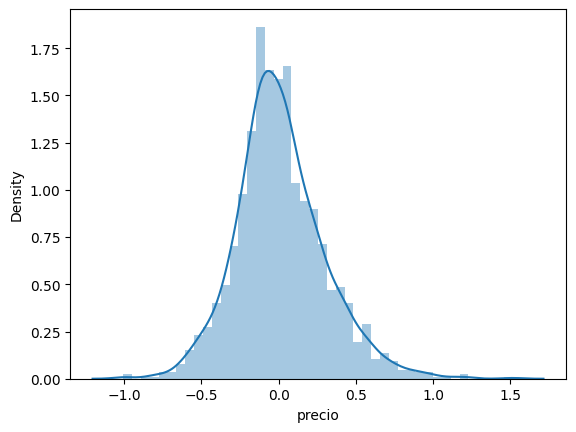

In [ ]:
sns.distplot((y_test - lgb_pred));
plt.show()